# Library Import and Set-Up

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer

tf.config.run_functions_eagerly(True)

gpu_devices = tf.config.list_physical_devices('GPU')
details = tf.config.experimental.get_device_details(gpu_devices[0])
print("Available GPU: ", details.get('device_name'))

2024-09-03 11:00:47.116263: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-03 11:00:47.201875: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-03 11:00:47.254822: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-03 11:00:47.274469: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-03 11:00:47.303541: I tensorflow/core/platform/cpu_feature_guar

Available GPU:  NVIDIA GeForce RTX 3060


I0000 00:00:1725341450.710394   18093 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725341450.807106   18093 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725341450.807212   18093 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725341450.808370   18093 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


# Load Dataset

In [2]:
rawdataset = pd.read_csv("./dataset/full_dataset.csv")

In [3]:
print("Full Dataset shape:", rawdataset.shape)

Full Dataset shape: (2231142, 7)


In [4]:
dataset = rawdataset[:1900]
dataset = dataset.drop(["link", "source"], axis=1)

In [5]:
print("Data shape:", dataset.shape)
dataset.head()

Data shape: (1900, 5)


,Unnamed: 0,title,ingredients,directions,NER
0,0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...","[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu..."
1,1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....","[""beef"", ""chicken breasts"", ""cream of mushroom..."
2,2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...","[""frozen corn"", ""cream cheese"", ""butter"", ""gar..."
3,3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...","[""chicken"", ""chicken gravy"", ""cream of mushroo..."
4,4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...","[""peanut butter"", ""graham cracker crumbs"", ""bu..."


# Pre-Processing the Data

In [6]:
def clean_text(txt):
    txt = "".join(v for v in txt if v not in '!"#$%&*+:;<=>?@[\]^_`{}~').lower()
    return txt

title = [clean_text(x) for x in dataset.title]
NER = [clean_text(x) for x in dataset.NER]
ingredients = [clean_text(x) for x in dataset.ingredients]
directions = [clean_text(x) for x in dataset.directions]

#### Combining ner, title, ingredients and directions data into a single string

In [7]:
finaldataset = []
for i in range(len(NER)):
    finaldataset.append(NER[i]+" | "+title[i]+" | "+ingredients[i]+" | "+directions[i]+ " ~ ")
max_length = 0
for i in finaldataset:
    max_length = max(max_length, len(i))
print("max_length:", max_length)
print()
print("Recipe at index 0:\n", finaldataset[0])

max_length: 1362

Recipe at index 0:
 brown sugar, milk, vanilla, nuts, butter, bite size shredded rice biscuits | no-bake nut cookies | 1 c. firmly packed brown sugar, 1/2 c. evaporated milk, 1/2 tsp. vanilla, 1/2 c. broken nuts (pecans), 2 tbsp. butter or margarine, 3 1/2 c. bite size shredded rice biscuits | in a heavy 2-quart saucepan, mix brown sugar, nuts, evaporated milk and butter or margarine., stir over medium heat until mixture bubbles all over top., boil and stir 5 minutes more. take off heat., stir in vanilla and cereal mix well., using 2 teaspoons, drop and shape into 30 clusters on wax paper., let stand until firm, about 30 minutes. ~ 


# Tokenizing the final dataset

#### Creating Tokens

In [8]:
tokenizer = Tokenizer(
    char_level=False,
    filters='',
    lower=False,
    split=' '
)
tokenizer.fit_on_texts(finaldataset)
#tokenizer.fit_on_texts(["~"])

vocab_size = len(tokenizer.word_index) + 1
print("Total words:", vocab_size)

text = ["pineapple condensed milk lemons pecans graham cracker crusts"]
token_list = tokenizer.texts_to_sequences(text)
print(text)
print(token_list)

Total words: 7317
['pineapple condensed milk lemons pecans graham cracker crusts']
[[184, 237, 91, 2857, 247, 193, 206, 1596]]


In [9]:
print("words and token:")
list(tokenizer.word_index.items())[100:110]

words and token:


[('garlic', 101),
 ('tomato', 102),
 ('cinnamon,', 103),
 ('sprinkle', 104),
 ('together', 105),
 ('egg', 106),
 ('5', 107),
 ('onions,', 108),
 ('put', 109),
 ('cup', 110)]

#### Vectorizing the dataset

In [10]:
finaldataset_token = tokenizer.texts_to_sequences(finaldataset)
print(finaldataset_token[2])
print()
print(tokenizer.sequences_to_texts([finaldataset_token[2]]))

[136, 208, 22, 31, 35, 101, 56, 15, 79, 2, 999, 133, 2, 7, 337, 42, 54, 136, 208, 1, 158, 42, 54, 22, 31, 837, 138, 4, 35, 837, 6, 8, 101, 56, 6, 8, 15, 28, 8, 79, 2, 5, 17, 2024, 3047, 65, 78, 583, 118, 3, 57, 41, 232, 18, 43, 327, 21, 16, 812, 854, 3, 44, 130, 1331, 55, 152, 215, 529, 508, 81, 291, 10]

['frozen corn, cream cheese, butter, garlic powder, salt, pepper | creamy corn | 2 (16 oz.) pkg. frozen corn, 1 (8 oz.) pkg. cream cheese, cubed, 1/3 c. butter, cubed, 1/2 tsp. garlic powder, 1/2 tsp. salt, 1/4 tsp. pepper | in a slow cooker, combine all ingredients. cover and cook on low for 4 hours or until heated through and cheese is melted. stir well before serving. yields 6 servings. ~']


# Creating N-gram sequences

In [11]:
input_sequences = []
for line in finaldataset:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

In [12]:
for i in input_sequences[0:10]:
    print(i, tokenizer.sequences_to_texts([i]))

[52, 11] ['brown sugar,']
[52, 11, 37] ['brown sugar, milk,']
[52, 11, 37, 66] ['brown sugar, milk, vanilla,']
[52, 11, 37, 66, 180] ['brown sugar, milk, vanilla, nuts,']
[52, 11, 37, 66, 180, 35] ['brown sugar, milk, vanilla, nuts, butter,']
[52, 11, 37, 66, 180, 35, 928] ['brown sugar, milk, vanilla, nuts, butter, bite']
[52, 11, 37, 66, 180, 35, 928, 488] ['brown sugar, milk, vanilla, nuts, butter, bite size']
[52, 11, 37, 66, 180, 35, 928, 488, 182] ['brown sugar, milk, vanilla, nuts, butter, bite size shredded']
[52, 11, 37, 66, 180, 35, 928, 488, 182, 200] ['brown sugar, milk, vanilla, nuts, butter, bite size shredded rice']
[52, 11, 37, 66, 180, 35, 928, 488, 182, 200, 678] ['brown sugar, milk, vanilla, nuts, butter, bite size shredded rice biscuits']


In [13]:
max_seq_len = max(len(x) for x in input_sequences)
print("Input Sequences Length:", len(input_sequences))
print("Max sequences Length:", max_seq_len)

Input Sequences Length: 172267
Max sequences Length: 232


# Padding the sequences with 0

In [14]:
print("Before padding")
print(input_sequences[3], len(input_sequences[3]))

Before padding
[52, 11, 37, 66, 180] 5


In [15]:
input_sequences = np.array(keras.utils.pad_sequences(input_sequences, maxlen=max_seq_len, padding = 'pre'))

In [16]:
print("After padding")
print(input_sequences[3], len(input_sequences[3]))

After padding
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0  52  11  37  66 180] 232


# Spliting Predictor and Predictand

In [17]:
features, labels = input_sequences[:, :-1], input_sequences[:, -1]

In [18]:
print("Features Shape:", features.shape)
print("Labels Shape:", labels.shape)
print()
print("Data at index 3")
print("Features:", tokenizer.sequences_to_texts([features[3]]))
print("Labels:", tokenizer.sequences_to_texts([[labels[3]]]))

Features Shape: (172267, 231)
Labels Shape: (172267,)

Data at index 3
Features: ['brown sugar, milk, vanilla,']
Labels: ['nuts,']


In [19]:
print("dataset size in disk")
print("Features:", features.nbytes/1e+9, "GB")
print("Labels:", labels.nbytes/1e+9, "GB")

dataset size in disk
Features: 0.159174708 GB
Labels: 0.000689068 GB


In [20]:
labels = keras.utils.to_categorical(labels, num_classes=vocab_size)

In [21]:
print("dataset size in disk")
print("Labels:", labels.nbytes/1e+9, "GB")
print("Labels Shape:", labels.shape)

dataset size in disk
Labels: 10.083821112 GB
Labels Shape: (172267, 7317)


#### Reducing dataset size

In [22]:
n = 0.1
slice_size = int(len(features)*n)
print("Slice size:", slice_size)

Slice size: 17226


In [23]:
features = features[:slice_size, :]
labels = labels[:slice_size]

In [24]:
print("Features Shape:", features.shape)
print("Labels Shape:", labels.shape)
print("dataset size in disk")
print("Features:", features.nbytes/1e+9)
print("Labels:", labels.nbytes/1e+9)

Features Shape: (17226, 231)
Labels Shape: (17226, 7317)
dataset size in disk
Features: 0.015916824
Labels: 1.008341136


# Model Training

In [25]:
def generator_model():
    model = keras.Sequential([
    keras.layers.Embedding(vocab_size, 256, input_length=max_seq_len),
    keras.layers.GRU(126),
    keras.layers.Dense(vocab_size, activation='softmax')
    ])
    model.compile(loss = 'categorical_crossentropy', 
              optimizer = keras.optimizers.Adam(learning_rate = 0.002),
              metrics = ['accuracy'])
    return model

In [26]:
model = generator_model()

/home/rahul/.local/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1725341479.689773   18093 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725341479.693239   18093 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725341479.693264   18093 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725341480.105187   18093 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725341480.105777   1809

In [27]:
history = model.fit(features, labels, epochs = 25, batch_size=64)

/home/rahul/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/25


2024-09-03 11:02:06.105147: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


270/270 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.0377 - loss: 7.3254
Epoch 2/25
270/270 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.1196 - loss: 5.7308
Epoch 3/25
270/270 ━━━━━━━━━━━━━━━━━━━━ 16s 59ms/step - accuracy: 0.2027 - loss: 4.7725
Epoch 4/25
270/270 ━━━━━━━━━━━━━━━━━━━━ 17s 62ms/step - accuracy: 0.2603 - loss: 4.1085
Epoch 5/25
270/270 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.3054 - loss: 3.5477
Epoch 6/25
270/270 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.3625 - loss: 3.0083
Epoch 7/25
270/270 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.4394 - loss: 2.5388
Epoch 8/25
270/270 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - accuracy: 0.5218 - loss: 2.0975
Epoch 9/25
270/270 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.5934 - loss: 1.7703
Epoch 10/25
270/270 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.6503 - loss: 1.5128
Epoch 11/25
270/270 ━━━━━━━━━━━━━━━━━━━━ 17s 63ms/step - accuracy: 0.6913 - loss: 1.2945
Epoch 12/25
270/270 ━━━━━━━━━━━━━━━━━━━━ 

#### Model Summary

In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (64, 231, 256)         │     1,873,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (64, 126)              │       145,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (64, 7317)             │       929,259 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,842,691 (33.73 MB)

 Trainable params: 2,947,563 (11.24 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,895,128 (22.49 MB)

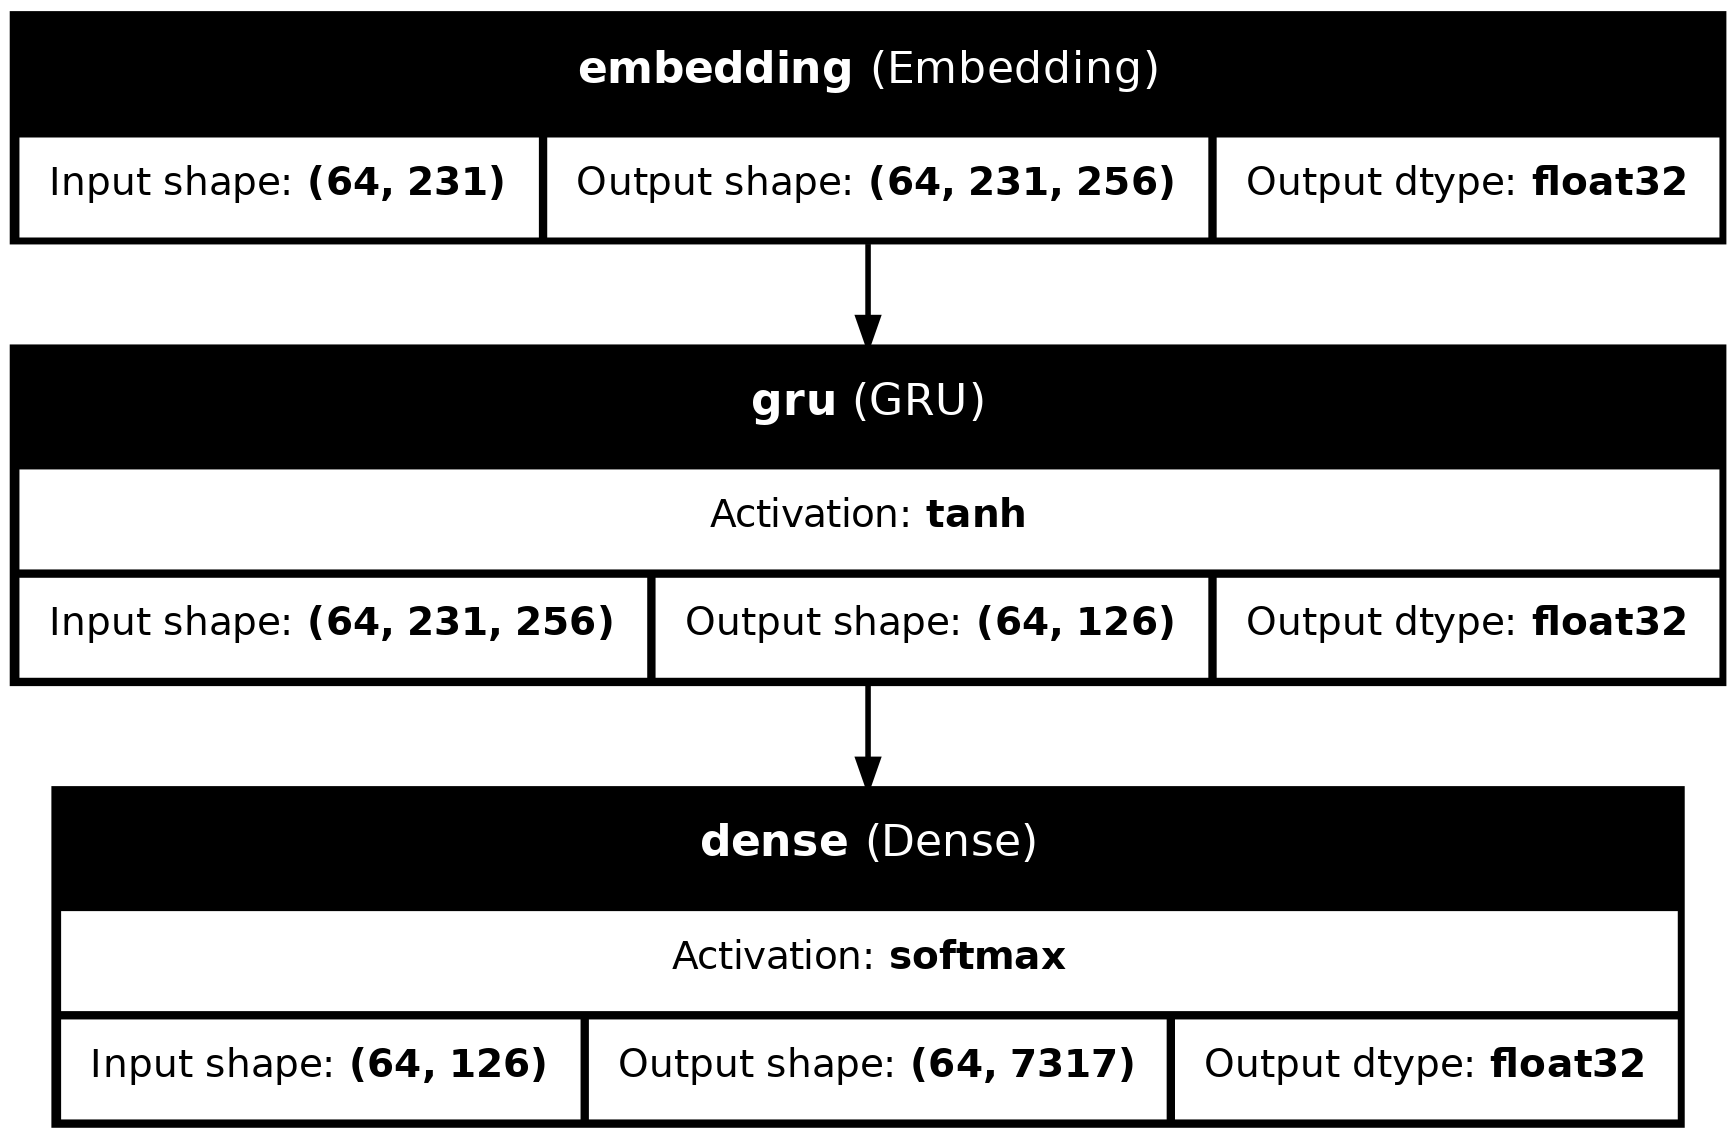

In [29]:
keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    show_layer_activations=True,
)

In [30]:
print("Model Accuracy:", max(history.history['accuracy']))
print("Loss:", min(history.history['loss']))

Model Accuracy: 0.9600023031234741
Loss: 0.2250538021326065


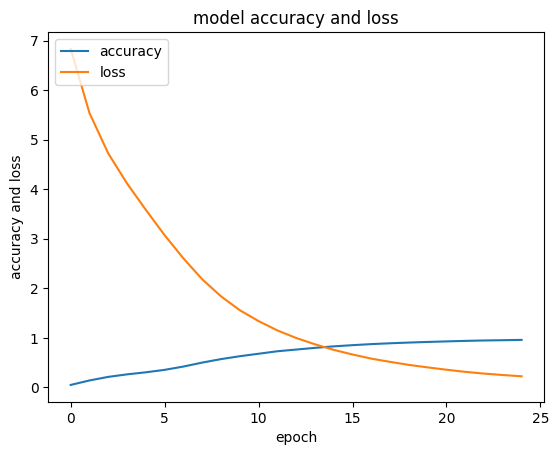

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('model accuracy and loss')
plt.ylabel('accuracy and loss')
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

# Model Testing

In [32]:
def generate_text(seed_text):
    for _ in range(max_seq_len):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = keras.utils.pad_sequences([token_list], maxlen=max_seq_len-1, padding = "pre")
        predicted = model.predict(token_list, verbose=0)
        predicted = np.argmax(predicted, axis=-1)
        
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                if(word == "~"):
                    return seed_text
                output_word = word
                break
        seed_text += " "+output_word
    return seed_text

In [33]:
ing = "hearts, mayonnaise, parmesan cheese"
print("Ingredients:", ing)
print("\nPredicted Recipe:")
print(generate_text(ing))

Ingredients: hearts, mayonnaise, parmesan cheese

Predicted Recipe:


/home/rahul/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


hearts, mayonnaise, parmesan cheese | artichoke dip | 2 cans or jars artichoke hearts, 1 c. mayonnaise, 1 c. parmesan cheese | drain artichokes and chop., mix with mayonnaise and parmesan cheese., after well mixed, bake, uncovered, for 20 to 30 minutes at 350u00b0., serve with crackers.


In [34]:
print("Actual Data:")
print(finaldataset[37])
print("\nPredicted Data:")
generate_text("salad supreme, italian dressing")

Actual Data:
salad supreme, italian dressing | summer spaghetti | 1 lb. very thin spaghetti, 1/2 bottle mccormick salad supreme (seasoning), 1 bottle zesty italian dressing | prepare spaghetti per package., drain., melt a little butter through it., marinate overnight in salad supreme and zesty italian dressing., just before serving, add cucumbers, tomatoes, green peppers, mushrooms, olives or whatever your taste may want. ~ 

Predicted Data:


'salad supreme, italian dressing | summer spaghetti | 1 lb. very thin spaghetti, 1/2 bottle mccormick salad supreme (seasoning), 1 bottle zesty italian dressing | prepare spaghetti per package., drain., melt a little butter through it., marinate overnight in salad supreme and zesty italian dressing., just before serving, add cucumbers, tomatoes, green peppers, mushrooms, olives or whatever your taste may want.'

# Saving the model and word index

In [35]:
model.save("Culinary-Companion-V0.1.keras")
with open('Culinary-Companion-word_index.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)